In [71]:
import numpy as np
import pandas as pd
import os, json 
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch
from torch import nn, optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.utils.data as data
from torch.autograd import Variable

In [72]:
# Load in dataset
df = pd.read_pickle('./problemsV8.pkl')
label = df['grade'].values
df = df.drop('grade',axis=1).values

# Split train and test data
train_dataset, test_dataset, train_label, test_label = train_test_split(df, label, test_size=.3, stratify=label)

In [73]:
# Convert dataset to tensor
class Dataset(data.Dataset):
    def __init__(self, df, label, smote=False, conv=False):
        self.dataset = df
        self.label = label
        if smote: self.__smote__() 
        
    def __getitem__(self, index):
            return torch.Tensor(self.dataset[index].astype(float)), self.label[index]
    def __len__(self):
        return self.dataset.shape[0]
    
    def __smote__(self):
        sm = SMOTE(random_state=27)
        self.dataset, self.label = sm.fit_sample(self.dataset, self.label)

In [74]:
# Network definition
class LinNet(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, num_classes)
        
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(F.relu(self.fc3(x)))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x
    
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv1d(1, 6, 5)
        self.pool = nn.MaxPool1d(2, 2)
        self.conv2 = nn.Conv1d(6, 16, 5)
        self.fc1 = nn.Linear(1536, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 13)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [75]:
# Get device info
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [76]:
# Variables
input_size = df.shape[1]
classes = np.unique(label)
num_classes = len(classes)
learning_rate = .001
batch_size = 32
num_epochs = 8
path = 'cnn.pt'

In [77]:
# Convert from DF to tensor
train_set = Dataset(train_dataset, train_label, smote=True)
trainloader = data.DataLoader(dataset = train_set, batch_size = batch_size, shuffle = True)

test_set = Dataset(test_dataset, test_label, smote=False)
testloader = data.DataLoader(dataset = test_set, batch_size = batch_size, shuffle = True)

In [78]:
# Initilalize network

# Conv = True for Conv : False for linear
conv = True

# model = NN(input_size=input_size, num_classes=num_classes).to(device)
model = ConvNet().to(device)

In [79]:
# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

In [80]:
# Train network
for epoch in range(num_epochs):
    for i, (route, labels) in enumerate(trainloader):
        route = Variable(route)
        labels = Variable(labels)
 
        optimizer.zero_grad()
    
        if conv: route = route.unsqueeze(1)
        outputs = model(route)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        if (i+1) % 500 == 0:
            print ('Epoch [%d/%d], Iter [%d] Loss: %.4f' %(epoch+1, num_epochs, i+1, loss.data))

Epoch [1/8], Iter [500] Loss: 2.0234
Epoch [2/8], Iter [500] Loss: 2.2843
Epoch [3/8], Iter [500] Loss: 1.6599
Epoch [4/8], Iter [500] Loss: 1.2479
Epoch [5/8], Iter [500] Loss: 1.5731
Epoch [6/8], Iter [500] Loss: 1.6433
Epoch [7/8], Iter [500] Loss: 1.3644
Epoch [8/8], Iter [500] Loss: 1.5107


Accuracy of the network: 34.302515517804636 %
              precision    recall  f1-score   support

         0.0       0.57      0.77      0.66       933
         1.0       0.13      0.08      0.10       178
         2.0       0.19      0.19      0.19       428
         3.0       0.22      0.20      0.21       352
         4.0       0.16      0.12      0.14       133
         5.0       0.13      0.03      0.04       319
         6.0       0.00      0.00      0.00        11
         7.0       0.17      0.24      0.20       422
         8.0       0.00      0.00      0.00         9
         9.0       0.19      0.16      0.17       187
        10.0       0.24      0.11      0.15        53
        11.0       0.22      0.08      0.12        24
        12.0       0.00      0.00      0.00        12

    accuracy                           0.34      3061
   macro avg       0.17      0.15      0.15      3061
weighted avg       0.30      0.34      0.31      3061

    Difference  Counts
0         

/Users/chrislb22/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<BarContainer object of 13 artists>

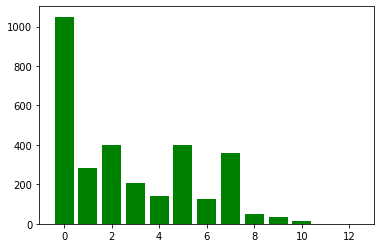

In [81]:
# Test Network
correct = total = 0
pred = t_label = np.array([])
with torch.no_grad():
    for data in testloader:
        route, labels = data
        if conv: route = route.unsqueeze(1)
        outputs = model(route)
        _, predicted = torch.max(outputs.data, 1)
        pred = np.append(predicted.numpy(), pred)
        t_label = np.append(labels.numpy(), t_label)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network: {accuracy} %'.format(accuracy=100 * correct / total))

print(classification_report(t_label, pred))

difference = abs(pred - t_label)
data = np.array(np.unique(difference, return_counts=True))
print(pd.DataFrame({'Difference': data[0], 'Counts': data[1]}))

# Successes within X grades
g_range = 1
trials = sum(data[1])
rel_successes = sum([ elem for cnt, elem in enumerate(data[1]) if cnt <= g_range])
print('Success within {g_range} grade{s}: {percent}%'.format(percent=(rel_successes/trials) * 100, g_range=g_range, s='s' if g_range > 1 else ''))

plt.bar(data[0], data[1], color='green')

In [82]:
# Save
torch.save(model, PATH)

/Users/chrislb22/anaconda3/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type ConvNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
